In [1]:
import matplotlib.pyplot as plt
from datetime import datetime
from functools import reduce
import numpy.ma as ma
import scipy.interpolate
import numpy as np
import xarray as xr
import sys,time,os

In [2]:
# Function to calculate the saturation vapor pressure over ice.
def satVapP_ice(t_in):
    a1 = 9.550426
    a2 = -5723.265
    a3 = 3.53068
    a4 = -0.00728332
    psatI = a1 + a2/t_in + a3*np.log(t_in) + a4*t_in
    psatI = np.exp(psatI)
    return psatI

## Read in-situ data and group by altitude

In [3]:
# Read in-situ data
daten = xr.open_dataset('obs/stratoclim2017.geophysika.0808_1.master.ci_eval.nc')

# Extract values between 6:20 and 6:48 UTC as in Lee et al. 2019
alt = daten['BEST:ALT'].sel(time=slice(datetime(2017,8,8,6,20),datetime(2017,8,8,6,48)))
h2o_flash = daten['BEST:H2O_gas'].sel(time=slice(datetime(2017,8,8,6,20),datetime(2017,8,8,6,48)))
h2o_fish = daten['BEST:H2O_enh'].sel(time=slice(datetime(2017,8,8,6,20),datetime(2017,8,8,6,48)))
iwc = daten['BEST:IWC'].sel(time=slice(datetime(2017,8,8,6,20),datetime(2017,8,8,6,48)))
temp = daten['BEST:TEMP'].sel(time=slice(datetime(2017,8,8,6,20),datetime(2017,8,8,6,48)))
theta = daten['BEST:THETA'].sel(time=slice(datetime(2017,8,8,6,20),datetime(2017,8,8,6,48)))
rhice_flash = daten['BEST:RH_ice_gas'].sel(time=slice(datetime(2017,8,8,6,20),datetime(2017,8,8,6,48)))
rhice_fish = daten['BEST:RH_ice_enh'].sel(time=slice(datetime(2017,8,8,6,20),datetime(2017,8,8,6,48)))

lat = daten['BEST:LAT'].sel(time=slice(datetime(2017,8,8,6,20),datetime(2017,8,8,6,48)))
lon = daten['BEST:LON'].sel(time=slice(datetime(2017,8,8,6,20),datetime(2017,8,8,6,48)))
print('In-situ lat min: ' + str(lat.min(skipna=True).values) + ' // In-situ lat max: ' + str(lat.max(skipna=True).values))
print('In-situ lon min: ' + str(lon.min(skipna=True).values) + ' // In-situ lon max: ' + str(lon.max(skipna=True).values))

zeit = daten['time'].sel(time=slice(datetime(2017,8,8,6,20),datetime(2017,8,8,6,48)))

In-situ lat min: 25.730899810791016 // In-situ lat max: 27.427600860595703
In-situ lon min: 85.18689727783203 // In-situ lon max: 85.31770324707031


In [4]:
# Extract corresponding altitudes and times for different variables according to their non-zero values
alt1 = alt.where((alt > 0) & (h2o_flash > 0) & (h2o_fish > 0)).values
t1 = zeit.where((alt > 0) & (h2o_flash > 0) & (h2o_fish > 0))
h2o_flash = h2o_flash.where((alt > 0) & (h2o_flash > 0) & (h2o_fish > 0))
h2o_fish = h2o_fish.where((alt > 0) & (h2o_flash > 0) & (h2o_fish > 0))

alt2 = alt.where((alt > 0) & (iwc > 0))
iwc = iwc.where((alt > 0) & (iwc > 0))

alt3 = alt.where((temp > 0) & (theta > 0))
temp = temp.where((temp > 0) & (theta > 0))
theta = theta.where((temp > 0) & (theta > 0))

alt4 = alt.where((rhice_flash > 0) & (rhice_fish > 0))
rhice_flash = rhice_flash.where((rhice_flash > 0) & (rhice_fish > 0))
rhice_fish = rhice_fish.where((rhice_flash > 0) & (rhice_fish > 0))

In [5]:
# Binning in altitude between <u> and <d> with <n> bins, which elements go in which bin?
# Make a multidimensional list of alt and h2o values in each.
u = 14000
d = 22000
n = 100

# np.digitze returns the indices of the bins to which each element in alt* belongs.
i1 = np.digitize(alt1,bins=np.linspace(u,d,n))
i2 = np.digitize(alt2,bins=np.linspace(u,d,n))

alt1_list = [[] for i in np.arange(n)]
t1_list = [[] for i in np.arange(n)]
h2o_flash_list = [[] for i in np.arange(n)]
h2o_fish_list = [[] for i in np.arange(n)]
alt2_list = [[] for i in np.arange(n)]
iwc_list = [[] for i in np.arange(n)]

# Group values into these bins
for elem_idx, group_idx in enumerate(i1):
    alt1_list[group_idx-1].append(alt1[elem_idx])
    t1_list[group_idx-1].append(t1[elem_idx])
    h2o_flash_list[group_idx-1].append(h2o_flash[elem_idx])
    h2o_fish_list[group_idx-1].append(h2o_fish[elem_idx])
    alt2_list[group_idx-1].append(alt2[elem_idx])
    iwc_list[group_idx-1].append(iwc[elem_idx])

In [6]:
# Calculate the mean across all items in a bin if there are at least 5 such items
h2o_flash_m = np.zeros((n,)); h2o_flash_m[:] = np.nan
h2o_fish_m = np.zeros((n,)); h2o_fish_m[:] = np.nan
iwc_m = np.zeros((n,)); iwc_m[:] = np.nan
    
for i in np.arange(n):
    if (len(h2o_flash_list[i]) > 5):
       h2o_flash_m[i] = sum(h2o_flash_list[i]) / len(h2o_flash_list[i])
    if (len(h2o_fish_list[i]) > 5):
       h2o_fish_m[i] = sum(h2o_fish_list[i]) / len(h2o_fish_list[i])
    if (len(iwc_list[i]) > 5):
       iwc_m[i] = sum(iwc_list[i]) / len(iwc_list[i])

In [16]:
# Read in the simulation values and create the same multi-dimensional list as for in-situ values.
basedir = '/scratch/b/b380873/0V2M0A0R/flight-track/'
sim0V2M0A0R = xr.open_dataset(basedir + 'CLCONV_3D_F10MIN_icon_tropic_flight-track_HL.nc')
lat = sim0V2M0A0R.lat
lon = sim0V2M0A0R.lon
z_s = sim0V2M0A0R.height
qv = sim0V2M0A0R.qv.sel(time=slice(datetime(2017,8,8,6,20),datetime(2017,8,8,6,50)),lat=slice(23,30),lon=slice(83,87)) # (4, 100, 280, 160)
qi = sim0V2M0A0R.qi.sel(time=slice(datetime(2017,8,8,6,20),datetime(2017,8,8,6,50)),lat=slice(23,30),lon=slice(83,87)) # (4, 100, 280, 160)

# Take the mean over the latitude and longitude and just extract the first time for simplicity.
qv_s = qv.isel(time=3).mean(dim={'lat','lon'})
qi_s = qi.isel(time=3).mean(dim={'lat','lon'})

# Multiply qv_s by 10^6 to translate kg kg-1 to ppmv.
mw_dryair = 28.97*1000    # kg air (mol air)-1
mw_watvap = 18.02*1000    # kg wv (mol wv)-1
conv = mw_dryair / mw_watvap
qv_s_ppmv = qv_s * conv * 10**6
qi_s_ppmv = qi_s * conv * 10**6

[]

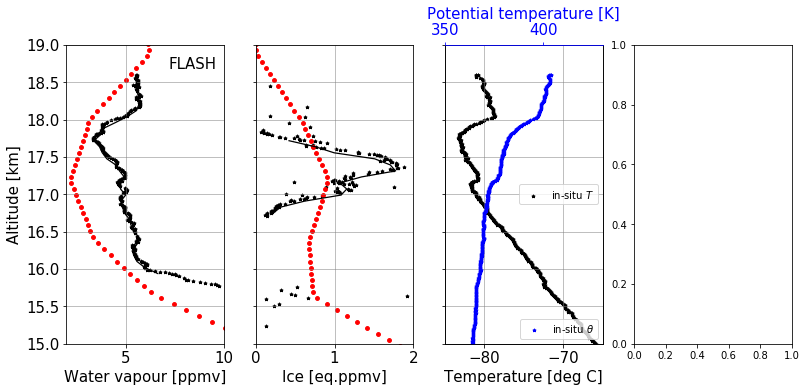

In [19]:
fs = 15
fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(13,5.5))
ax[0].grid(b=True,which='both',axis='both',color='gray',linewidth=0.5)
ax[0].scatter(h2o_flash,alt1/1000,color='k',s=10,marker='*',label='FLASH')
#ax[0].scatter(h2o_fish,alt1/1000,color='gray',s=10,marker='d',label='FISH')
ax[0].scatter(qv_s_ppmv,z_s/1000,marker='o',color='r',s=15,label='ICON')
ax[0].plot(h2o_flash_m,np.linspace(u,d,n)/1000,linewidth=1.25,color='k')
#ax[0].plot(h2o_fish_m,np.linspace(u,d,n)/1000,linewidth=1.25,color='gray')
#ax[0].plot([4,4],[14,21],linewidth=0.75,linestyle='--',color='k')
ax[0].set_xlim([2,10])
ax[0].set_ylim([15,19])
ax[0].set_xlabel('Water vapour [ppmv]',fontsize=fs)
ax[0].set_ylabel('Altitude [km]',fontsize=fs)
ax[0].text(0.65,0.92,'FLASH',fontsize=fs,transform=ax[0].transAxes)
ax[0].tick_params('both',labelsize=fs)

ax[1].grid(b=True,which='both',axis='both',color='gray',linewidth=0.5)
ax[1].scatter(iwc,alt2/1000,color='k',s=10,marker='*')
ax[1].scatter(qi_s_ppmv,z_s/1000,marker='o',color='r',s=15)
ax[1].plot(iwc_m,np.linspace(u,d,n)/1000,linewidth=1.25,color='k')
ax[1].set_ylim([15,19])
ax[1].set_xlim([0,2])
ax[1].set_xlabel('Ice [eq.ppmv]',fontsize=fs)
ax[1].tick_params('both',labelsize=fs)
ax[1].set_yticklabels([])

ax[2].grid(b=True,which='both',axis='both',color='gray',linewidth=0.5)
ax2 = ax[2].twiny()
ax[2].scatter(temp-273,alt3/1000,color='k',s=10,marker='*',label=r'in-situ $T$')
ax2.scatter(theta,alt3/1000,color='b',s=10,marker='*',label=r'in-situ $\theta$')
#ax[2].scatter(T_s_profile-273,z_s/1000,marker='o',color='r',s=15,label='ICON $T$')
#ax2.scatter(theta_s_profile,z_s/1000,marker='o',color='deepskyblue',s=15,label=r'ICON $\theta$')
ax[2].set_ylim([15,19])
ax[2].set_xlim([-85,-65]); ax2.set_xlim([350,430])
ax[2].set_xlabel('Temperature [deg C]',fontsize=fs)
ax2.set_xlabel('Potential temperature [K]',fontsize=fs,color='b')
ax2.spines['top'].set_color('b'); ax2.tick_params(axis='x',colors='b')
ax[2].legend(loc='center right')
ax2.legend(loc='lower right')
ax[2].tick_params('both',labelsize=fs)
ax2.tick_params('both',labelsize=fs)
ax2.set_yticklabels([])